# Example MNIST classifier

This notebook is the same as `example_classifier` in Multi-GPU mode. 

Note that my machine only has 1 GPU but it is possible to split 1 physical GPU in multiple *logical GPU*. It is useless in term of performances but it is useful to experiment multi-GPU support.

Mulsit-GPU training in `tensorflow` (my understanding) :
1. All model's parameters are replicated on all GPU. 
2. The dataset will produces `GLOBAL_BATCH_SIZE` data at each iteration and each replica (*gpu*) will get a fraction of it (`GLOBAL_BATCH_SIZE = batch_size * num_replicas`).
3. Each model (1 per replica) will perform a `training_step` :
    - Predicts independently its batch
    - Compute the loss **per sample** for this replica
    - Sums per_sample losses and divides it by `GLOBAL_BATCH_SIZE`
    - Computes gradients for this replica
    - Updates metrics (for this replica)
    - Returns the loss.
4. The loss per replica will be *reduced* in a global loss by summing them (see below for mathematical details).
5. Gradients of each replica will be summed then `backpropagation` is performed (`weights update`).
6. It returns the loss for this iteration.

Mathematical details :

To compute the loss on single GPU, classical way is to compute the loss per sample and take the mean (i.e. sum them and divide by `batch_size`). However, in a multi-GPU context, each replica gets only a portion of samples then we cannot divide by `batch_size`.

The trick is to compute the *global loss* by summing *per_replica_loss* which are defined as *the sum over given samples divided by the GLOBAL_BATCH_SIZE* which is mathematically equivalent as computing the *mean over all samples* !

This has a direct impact on the code as therefore, losses must return **per sample loss** and **not** a scalar value.

## Imports + model initialization

In [1]:
import pandas as pd
import tensorflow as tf

from utils import split_gpus, set_display_options, plot, plot_multiple
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.classification.base_classifier import BaseClassifier

# split my single GPU to 2 logical GPU to test the multi-GPU support
split_gpus(n = 2, memory = 2048)

set_display_options()

strat = tf.distribute.MirroredStrategy()

model_name = 'mnist_classifier_dist'

# physical GPU : 1
# logical GPU : 2
NCCL is not supported when using virtual GPUs, fallingback to reduction to one device
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
input_shape = (28, 28, 1)
with strat.scope():
    model = BaseClassifier(input_shape, labels = list(range(10)), nom = model_name)

print(model)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcas

## Model instanciation + dataset loading

In [2]:
with strat.scope():
    model = BaseClassifier(nom = model_name)

    model.compile()

print(model)
model.summary()

Model restoration...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Reduce to /job:localhost/replica:0/task:0/devic

In [3]:
ds = get_dataset('mnist')

train, valid = ds['train'], ds['test']
print(train)
print(valid)

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


## Training + history analysis

Some observations : 
- The final loss / accuracy is as good as in single GPU : the difference is just the `batch_size` actually (2 * 64 instead of 1 * 64).
- The `batch_size` is the same (*64*) but the number of iterations / epochs is 2 times lower : proof that 2 times more data are processed in parallel !
- The time per epoch is slightly higher : at the last epoch, times are equivalent and it could be explained because the 2 replics must be synchronized which takes some time. Therefore, making 2 GPU on a single physical GPU is not relevant, just double the `batch_size` and it will be faster :p

The multi-GPU support **do not increase the memory size** so if your model does not fit in memory, having 2 times the same GPU will not help you. Multi-GPU can be useful to increase the `batch_size` used for training which can make your training **faster** but **not** *better* ;)

In [4]:
model.train(
    train, validation_data = valid,
    epochs = 5, batch_size = 64,
    augment_prct = 0.25
)

Training config :
HParams :
- augment_prct	: 0.25
- batch_size	: 64
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 1024
- epochs	: 5
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 2 GPU

Epoch 1 / 5
Epoch 1/5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

===== History =====
       loss  sparse_categorical_accuracy  val_loss  val_sparse_categorical_accuracy
0  0.493494                     0.840200  0.158500                           0.9656
1  0.182548                     0.943500  0.068590                           0.9787
2  0.142900                     0.956150  0.054346                           0.9832
3  0.119904                     0.963950  0.047910                           0.9838
4  0.107065                     0.966833  0.043114                           0.9855


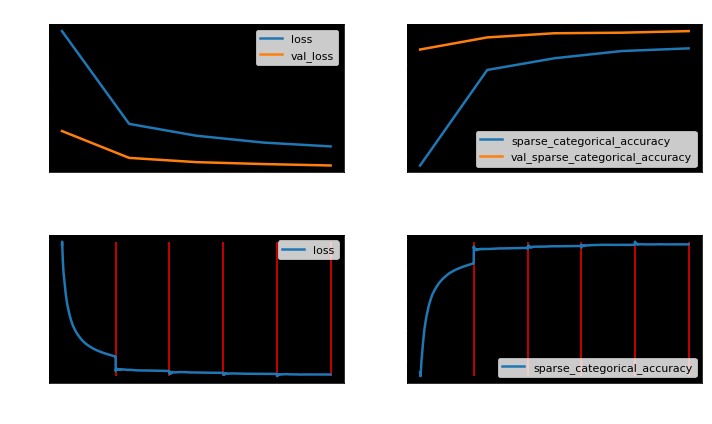

In [5]:
print(model.history)
model.plot_history()

In [6]:
print("Training config :")
print(pd.DataFrame(model.history.trainings_config))
print("\nTraining informations :")
print(pd.DataFrame(model.history.trainings_infos))


Training config :
   augment_prct  batch_size  epochs  pred_step  shuffle_size  test_batch_size  test_size train_batch_size train_size  \
0          0.25          64       5         -1          1024                1          4             None       None   

   train_times valid_batch_size valid_size  valid_times  verbose  
0            1             None       None            1        1  

Training informations :
                         end  final_epoch  interrupted                      start  start_epoch       time
0 2021-12-23 12:41:06.938079            4        False 2021-12-23 12:39:23.644999           -1  103.29308


## Prediction

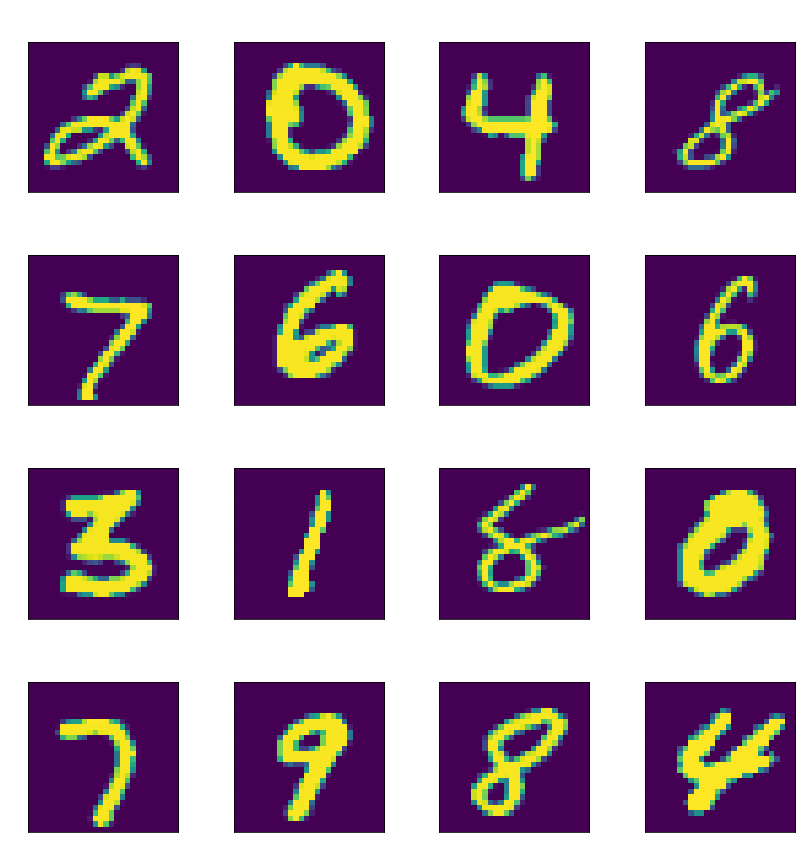

In [7]:
predictions = {}
for i, data in enumerate(valid):
    if i >= 16: break
    image, label = data['image'], data['label']
    
    pred, score = model.predict(image)[0]
    predictions['Pred #{}\nClass : {} ({} ({:.2f}%))'.format(i, label, pred, score * 100)] = image

plot_multiple(** predictions, ncols = 4, plot_type = 'imshow')

## Test dataset performance

These 3 lines allow you to debug your processing pipeline and test its performances

In [9]:
config = model.get_dataset_config(is_validation = False, batch_size = 128)

ds_train = prepare_dataset(train, ** config, debug = True)
test_dataset_time(ds_train, steps = 1000)

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 497.70it/s]


469 batchs in 0.946 sec sec (496.006 batch / sec)

Time estimated for all dataset (469 batch) : 64h 37min 6sec
Batch infos : 
Element 0 : shape : (96, 28, 28, 1) - type : <dtype: 'float32'> - min : 0.000 - max : 1.000
Element 1 : shape : (96,) - type : <dtype: 'int32'> - min : 0.000 - max : 9.000


0.9455533027648926